In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Enable multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()  # Automatically uses available GPUs
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

with strategy.scope():
    # Load and preprocess MNIST dataset
    (train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()
    
    # Normalize the data
    all_data = np.concatenate((train_data, test_data), axis=0).astype("float32") / 255.0
    all_labels = np.concatenate((train_labels, test_labels), axis=0)
    
    # Expand dimensions for compatibility with DenseNet and ResNet (add channel dimension)
    all_data = np.expand_dims(all_data, axis=-1)
    all_data = np.tile(all_data, (1, 1, 1, 3))  # Convert to 3 channels
    
    # Resize images to 64x64 for DenseNet121 and ResNet50
    all_data_resized = np.array([tf.image.resize(image, (64, 64)).numpy() for image in all_data])
    
    # Split into train, validation, and test sets
    data_train, data_temp, labels_train, labels_temp = train_test_split(
        all_data_resized, all_labels, test_size=0.4, random_state=42
    )
    data_val, data_test, labels_val, labels_test = train_test_split(
        data_temp, labels_temp, test_size=0.5, random_state=42
    )

Number of GPUs: 2
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
resnet_model = Sequential()
densenet_model = Sequential()

densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3),pooling='max',classes=10)
resnet_base = ResNet50(weights='imagenet',include_top=False, input_shape=(64, 64, 3),pooling='max',classes=10)

for layer in resnet_base.layers:
    layer.trainable = False

resnet_model.add(resnet_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(128,activation='relu'))
resnet_model.add(Dense(10,activation='softmax'))

densenet_model.add(resnet_base)
densenet_model.add(Flatten())
densenet_model.add(Dense(512,activation='relu'))
densenet_model.add(Dense(512,activation='relu'))
densenet_model.add(Dense(128,activation='relu'))
densenet_model.add(Dense(10,activation='softmax'))

resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
densenet_model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
history = resnet_model.fit(
        data_train, labels_train,
        validation_data=(data_val,labels_val),
        epochs=50,
        batch_size=1024
    )

Epoch 1/50


I0000 00:00:1734018482.186023      96 service.cc:145] XLA service 0x7f8de004c250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734018482.186079      96 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734018482.186083      96 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/42 ━━━━━━━━━━━━━━━━━━━━ 11:01 16s/step - accuracy: 0.1025 - loss: 2.4037

I0000 00:00:1734018491.321648      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 585ms/step - accuracy: 0.5117 - loss: 1.4669 - val_accuracy: 0.8006 - val_loss: 0.5726
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0.8638 - loss: 0.4233 - val_accuracy: 0.8344 - val_loss: 0.4547
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.8920 - loss: 0.3324 - val_accuracy: 0.9217 - val_loss: 0.2671
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.9305 - loss: 0.2252 - val_accuracy: 0.8993 - val_loss: 0.3000
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.9314 - loss: 0.2114 - val_accuracy: 0.9385 - val_loss: 0.1920
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.9478 - loss: 0.1666 - val_accuracy: 0.8223 - val_loss: 0.5319
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.9118 - loss: 0.2614 - val_accuracy: 0.9489 - val_loss: 0.1649
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - accuracy: 0.9556 - loss: 0.1446 - val_accuracy: 0.935

438/438 - 5s - 12ms/step - accuracy: 0.9867 - loss: 0.0409
Resnet Test Accuracy: 98.67%


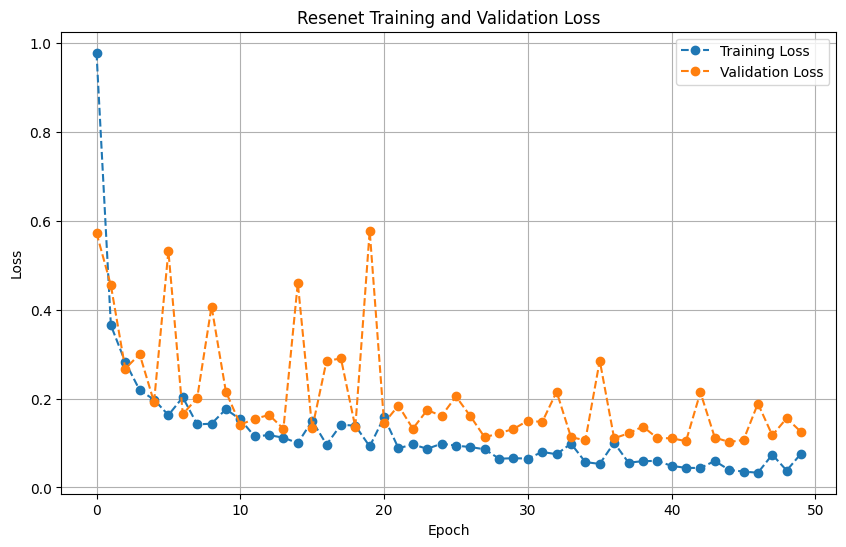

In [11]:
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(data_test, labels_test, verbose=2)
print(f"Resnet Test Accuracy: {resnet_test_accuracy * 100:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title(f'Resenet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
history_d = densenet_model.fit(
        data_train, labels_train,
        validation_data=(data_val,labels_val),
        epochs=50,
        batch_size=1024
    )

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 462ms/step - accuracy: 0.4886 - loss: 1.6134 - val_accuracy: 0.7788 - val_loss: 0.6742
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 286ms/step - accuracy: 0.8493 - loss: 0.4750 - val_accuracy: 0.8567 - val_loss: 0.4238
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 296ms/step - accuracy: 0.8810 - loss: 0.3623 - val_accuracy: 0.9067 - val_loss: 0.2919
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 305ms/step - accuracy: 0.9230 - loss: 0.2442 - val_accuracy: 0.9007 - val_loss: 0.2869
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 301ms/step - accuracy: 0.9286 - loss: 0.2214 - val_accuracy: 0.9401 - val_loss: 0.1944
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.9469 - loss: 0.1724 - val_accuracy: 0.9332 - val_loss: 0.2064
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step - accuracy: 0.9470 - loss: 0.1674 - val_accuracy: 0.9257 - val_loss: 0.2293
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step - accuracy: 0.9402 - loss: 0.1868 - val_accu

438/438 - 5s - 11ms/step - accuracy: 0.9816 - loss: 0.0549
Densenet Test Accuracy: 98.16%


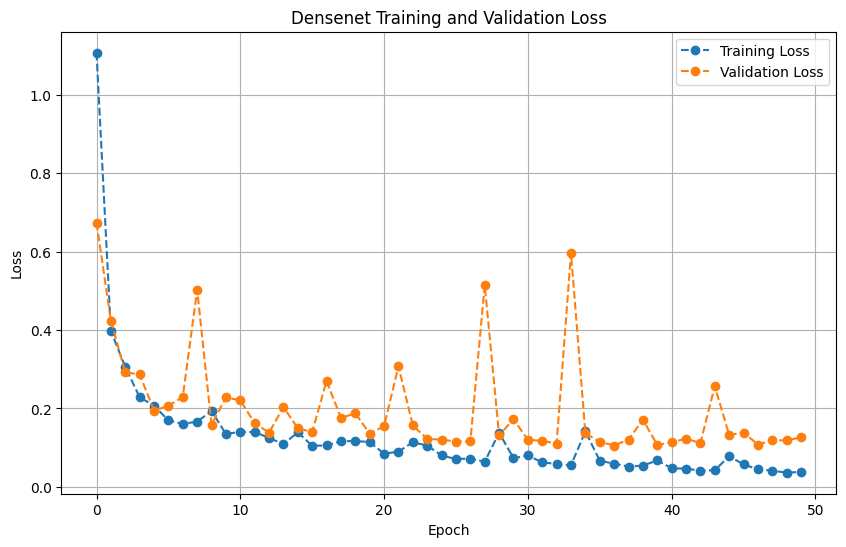

In [16]:
densenet_test_loss, densenet_test_accuracy = densenet_model.evaluate(data_test, labels_test, verbose=2)
print(f"Densenet Test Accuracy: {densenet_test_accuracy * 100:.2f}%")


plt.figure(figsize=(10, 6))
plt.plot(history_d.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history_d.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title(f'Densenet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()